In [2]:
import sys
sys.path.append("../")
import skimage
import matplotlib.pyplot as plt

from unet.networks.unet3d import UNet3D
from unet.augmentations.augmentations import labels_to_edges_and_centroids, normalize_img, edges_and_centroids

import torch

/Users/ctromans/miniconda3/envs/maddox-dbp/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
# model = UNet3D(
#     input_channels=1, num_classes=3, network_depth=4, activation=None, dropout_probability=0.1
# )

# from unet.networks.unet3d import UnetModel
# model = UnetModel(
#     1, 3
# )

model = UNet3D(
    in_channels=1, out_channels=3, f_maps=32
)

weights = torch.load("/Users/ctromans/image-analysis/UNet_3D_C_elegans/experiments/014/best_last_checkpoints/best_checkpoint.pytorch", map_location=torch.device('cpu'))["state_dict"]
# weights = torch.load("/Users/ctromans/image-analysis/UNet_3D_C_elegans/experiments/015/best_last_checkpoints/best_checkpoint.pytorch", map_location=torch.device('cpu'))["state_dict"]

model.load_state_dict(weights)
# weights

<All keys matched successfully>

In [15]:
# input_image = skimage.io.imread("/Users/ctromans/image-analysis/UNet_3D_C_elegans/patch_data/image/mx85-nd-acqusition-8-ch1_patch69.tif") # Seed
input_image = skimage.io.imread("/Users/ctromans/image-analysis/UNet_3D_C_elegans/patch_data/image/mx85-nd-acqusition-1-ch1_patch29.tif") # unseen
norm_image = normalize_img(input_image)
img = torch.from_numpy(norm_image)

print(img.size())

# Add batch dim
img = torch.unsqueeze(torch.unsqueeze(img, 0),0)

print(img.size())

pred = model(img)

torch.Size([24, 200, 200])
torch.Size([1, 1, 24, 200, 200])


In [16]:
# Mask transform
# input_mask = skimage.io.imread("/Users/ctromans/image-analysis/UNet_3D_C_elegans/patch_data/labels/mx85-nd-acqusition-8-ground-truth_patch69.tif") # Seed
input_mask = skimage.io.imread("/Users/ctromans/image-analysis/UNet_3D_C_elegans/patch_data/labels/mx85-nd-acqusition-1-ground-truth_patch29.tif") # unseen


mask = edges_and_centroids(input_mask)

mask.min(), mask.max()


(0.0, 1.0)

3.0288538e-16 1.0


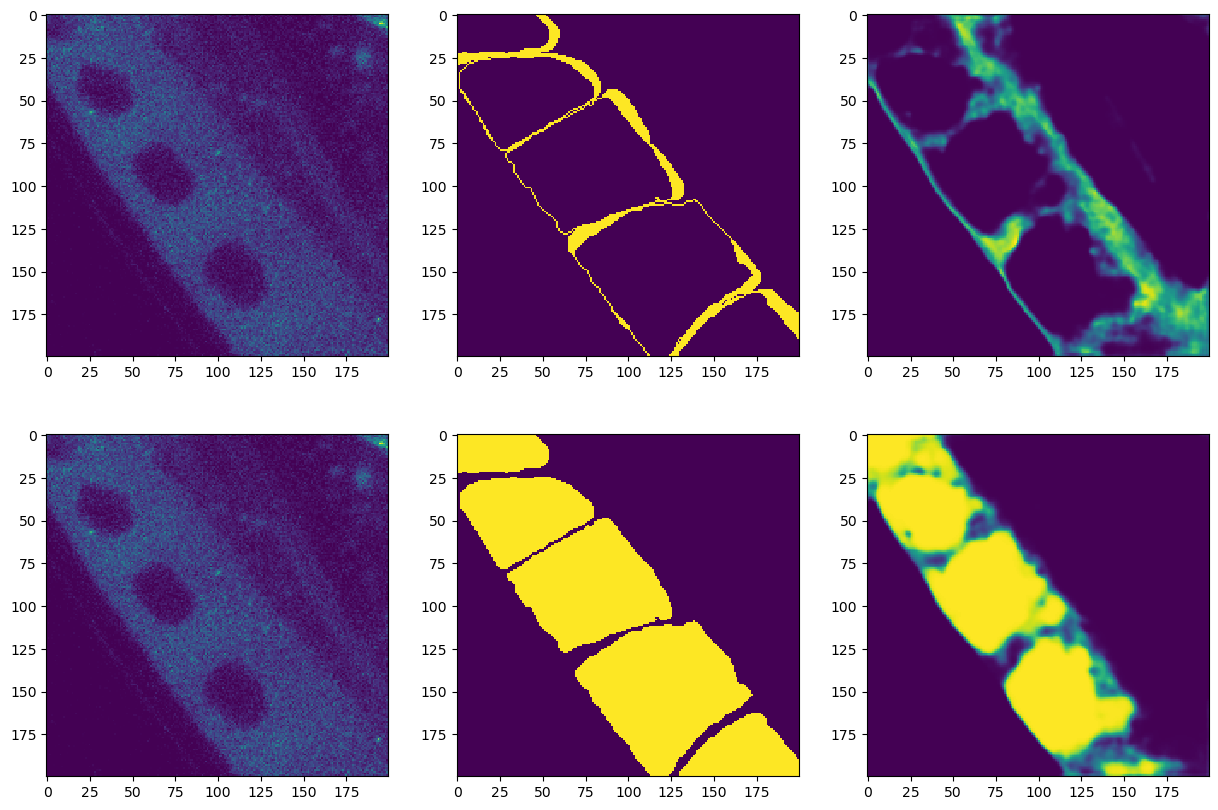

In [17]:


ch = 1
out = pred.detach().sigmoid().numpy()[0,...]

# out = out > 0.5

print(out.min(), out.max())

z = 14
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
ax[0,0].imshow(input_image[z,...])
ax[0,1].imshow(mask[1,z,...])
ax[0,2].imshow(out[1,z,...])

ax[1,0].imshow(input_image[z,...])
ax[1,1].imshow(mask[2,z,...])
ax[1,2].imshow(out[2,z,...])

In [18]:
fig.savefig("prediction_comparison.tiff", dpi=300)

In [19]:
skimage.io.imsave("pred_output.tiff", out)



(3, 24, 200, 200)


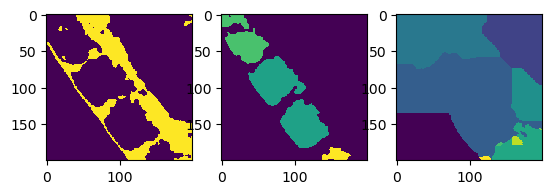

In [56]:
import skimage
print(out.shape)
markers = skimage.measure.label(out[2,...] > 0.9)
edges = out[1,...] > 0.1
ws = skimage.segmentation.watershed(edges, markers)

fig, ax = plt.subplots(1, 3)
ax[0].imshow(edges[12,...])
ax[1].imshow(markers[12,...])
ax[2].imshow(ws[12,...])

In [20]:
import monai
import torch
import numpy as np

full_img = skimage.io.imread("/Users/ctromans/image-analysis/callumtc_projects/2020_09_25_COBA_UNC_Maddox/single_channel_data/mdx85/C1-ND Acquisition7.tif").astype(np.float32)
full_img = torch.from_numpy(full_img)
full_img = full_img.unsqueeze(0).unsqueeze(0)

full_prediction = monai.inferers.sliding_window_inference(
    full_img,
    (24, 200, 200),
    1,
    model
)

: 

: 

In [8]:
import sklearn.metrics



y_pred = pred.sigmoid().detach().cpu().numpy().flatten()
y_pred = y_pred > 0.5

y_true = torch.from_numpy(mask)
y_true = y_true.long().detach().cpu().numpy().flatten()

sklearn.metrics.accuracy_score(y_true, y_pred)

0.9070315972222223

In [26]:
((80 * 400) / 60) / 60


8.88888888888889